In [1]:
import tensorflow as tf ### models
import numpy as np
import pandas as pd ### reading and procesing data
import seaborn as sns ### visualizacion
from tensorflow import keras
import matplotlib.pyplot as plt
import pydot as pydot
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Normalization, Dense, InputLayer, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

In [2]:
"""
#DEFINIMOS LA TAREA:

En este caso crearemos un modelo para clasificar si una celula posee malaria o no. Para ello utilizaremos una red neuronal convolucional.
La malaria es una enfermedad causada por un parásito Plasmodium, el cual es trasmitido por la picadura de un mosquito infectado. 
Sólo el género anófeles del mosquito transmite la malaria. Los síntomas de esta enfermedad pueden incluir fiebre, vómito y/o dolor de cabeza.
Las muestras de sangre son examinadas con un microscopio para diagnosticar la malaria, en donde el parásito es detectado dentro de los glóbulos rojos.
Ante esto estamos frente a una clasificacion binaria ya que nuestro paciente solo podra tener la enfermedad o no tenerla

En las muestras de las celulas nos daremos cuenta si estas estan infectadas por el color. 
Utilizamos una imagen, de una determinada cantidad de pixeles. Estaremos haciendo una clasificacion de imagenes.
"""

'\n#DEFINIMOS LA TAREA:\n\nEn este caso crearemos un modelo para clasificar si una celula posee malaria o no. Para ello utilizaremos una red neuronal convolucional.\nLa malaria es una enfermedad causada por un parásito Plasmodium, el cual es trasmitido por la picadura de un mosquito infectado. \nSólo el género anófeles del mosquito transmite la malaria. Los síntomas de esta enfermedad pueden incluir fiebre, vómito y/o dolor de cabeza.\nLas muestras de sangre son examinadas con un microscopio para diagnosticar la malaria, en donde el parásito es detectado dentro de los glóbulos rojos.\nAnte esto estamos frente a una clasificacion binaria ya que nuestro paciente solo podra tener la enfermedad o no tenerla\n\nEn las muestras de las celulas nos daremos cuenta si estas estan infectadas por el color. \nUtilizamos una imagen, de una determinada cantidad de pixeles. Estaremos haciendo una clasificacion de imagenes.\n'

In [3]:
"""
DATA PREPARATION:

El conjunto de datos de Malaria contiene un total de 27.558 imágenes de células con instancias iguales de células parasitadas y no infectadas 
de las imágenes de diapositivas de frotis de sangre delgada de células segmentadas.
La altura de pixeles varia un poco, por lo que no tienen todas las imagenes la misma cantidad de pixeles.
"""

dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised=True, shuffle_files=True, split=['train'])

In [4]:
def split(dataset, TRAIN_RATIO, VAL_RATIO):
    DATA_SIZE = len(dataset)
    
    train_size = int(TRAIN_RATIO * DATA_SIZE)
    val_size = int(VAL_RATIO * DATA_SIZE)
    test_size = DATA_SIZE - train_size - val_size

    # Dividir el dataset
    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [5]:
# Ratios de división
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Dividir el dataset
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO)

# Verificar la cantidad de datos en cada conjunto
print(f'Train dataset size: {len(list(train_dataset))}')
print(f'Validation dataset size: {len(list(val_dataset))}')
print(f'Test dataset size: {len(list(test_dataset))}')

Train dataset size: 22046
Validation dataset size: 2755
Test dataset size: 2757


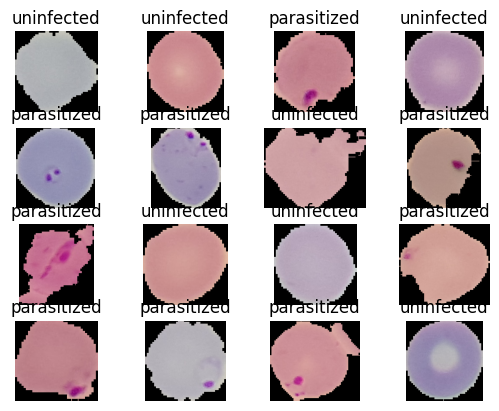

In [6]:
"""VISUALIZACION"""
for i, (image,label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [7]:
# Función de redimensionamiento y reescalado
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

In [8]:
"""
DATA PROCESSING

Vamos a procesar el tamaño de nuestras imagenes para luego normalizarlo
En nuestro caso normalizaremos a 224x224 pero en algunos casos se puede estandarizar el tamaño de los pixeles.
"""

# Aplicar la función a cada conjunto de datos
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)


In [9]:
# Definir el tamaño de lote
BATCH_SIZE = 32

# Configurar los datasets para el entrenamiento y test
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(1)
#No nos hace falta hacerlo para el test set ya que no necesitamos mezclarlo ni premezclarlo, pero si para el train y el validation set.
#Esto se hace para que tengan las mismas dimensiones.

In [10]:
"""
Para este ejercicio utilizaremos redes neuronales convulcionales o CNN. Las CNN se utilizan para el procesar imagenes.
"""

'\nPara este ejercicio utilizaremos redes neuronales convulcionales o CNN. Las CNN se utilizan para el procesar imagenes.\n'

In [11]:
# Definir el modelo LeNet
lenet_model = keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(), #Normalizamos estandarizando -> (X - Media) \ desviacion estandar
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2), #Max pool usa el valor maximo del pool en cuestion

    Flatten(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid'), #Solo tenemos un output ya que puede estar o no infectada

])

c:\Users\Gentile\Music\jemas\Modelo de regresion lineal\myenv\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [13]:
# Compilar el modelo
lenet_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']  # Cambiado a una lista
)

In [14]:
#Entrenamos nuestro modelo
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=1, verbose=1)

689/689 ━━━━━━━━━━━━━━━━━━━━ 139s 200ms/step - accuracy: 0.8140 - loss: 0.4163 - val_accuracy: 0.8479 - val_loss: 0.9550


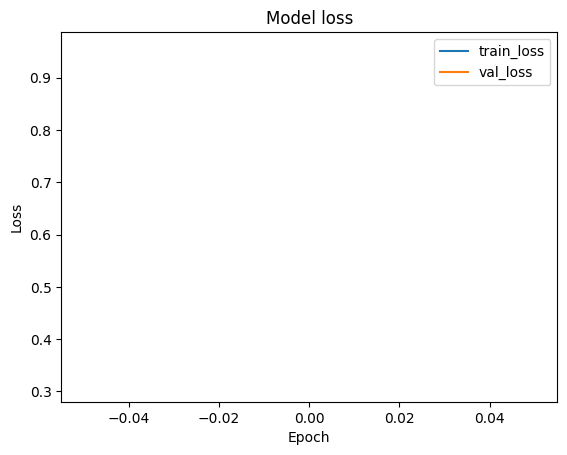

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

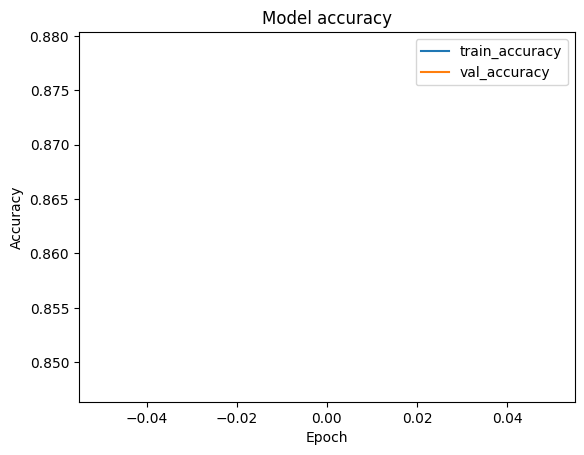

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [17]:
lenet_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8416 - loss: 1.0162


[1.0312328338623047, 0.8429452180862427]

In [18]:
def parasite_or_not(x):
    if (x<0.5):
        return str('Inf')
    else:
        return str('No inf')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


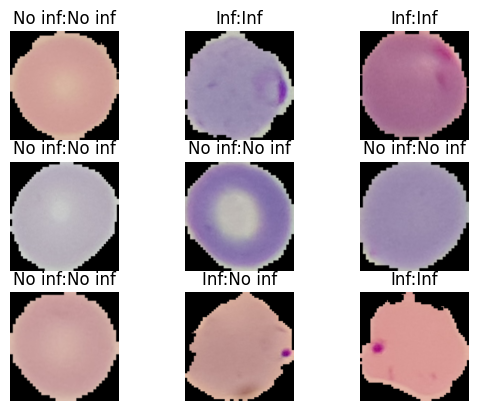

In [19]:
for i, (image, label) in enumerate(test_dataset.take(9)):

    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0]) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0]))))

    plt.axis('off')